In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

import optuna
from optuna.trial import TrialState

import plotly



## Assignment 1

* Train and Evaluate an MLP Classifier on the FashionMNIST dataset using PyTorch


We start with downloading of FashionMNIST training and testing

In [3]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Lets check the size of datasets

In [4]:
N_TRAIN_EXAMPLES = len(train_dataset)
N_VALID_EXAMPLES = len(test_dataset)
print(f"# Images Train: {N_TRAIN_EXAMPLES}")
print(f"# Images Test:  {N_VALID_EXAMPLES}")

# Images Train: 60000
# Images Test:  10000


Lets check the shape of tensors and format of labels

In [5]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


Lets look at some random samples

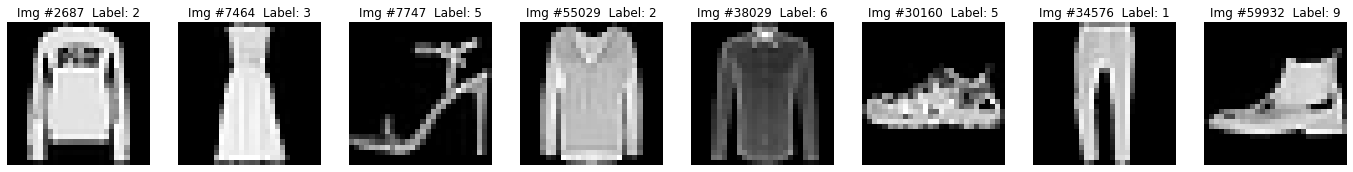

In [6]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(28,28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

Setting up Dataloaders

In [7]:
BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

In [8]:
def get_mnist():
    train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

    eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    return train_loader, eval_loader

In [9]:
train_loader, eval_loader = get_mnist()

Lets check the shapes of the batches

In [10]:
imgs, labels = next(iter(eval_loader))
print(f"{imgs.shape = }")
print(f"{labels.shape = }")

imgs.shape = torch.Size([1024, 1, 28, 28])
labels.shape = torch.Size([1024])


## Create a model

In [12]:
class Model(nn.Module):
    """
    MLP 
    """
    def __init__(self, input_dim=784, hidden_layers_dims=[128, 64], output_dim=10, activation=nn.ReLU):
        """ Model initalizer """
        super().__init__()

        self.layers = nn.Sequential()
        num_neurons = [input_dim] + hidden_layers_dims + [output_dim]
        for i, in_dims in enumerate(num_neurons[:-2]):
            out_dims = num_neurons[i+1]
            self.layers.add_module(f"{i*2} | Linear_{i:<5}", nn.Linear(in_features=in_dims, out_features=out_dims, bias=True))
            self.layers.add_module(f"{i*2+1} | Activation_{i}", activation())
        self.layers.add_module(f"{len(num_neurons)} | Linear_{len(num_neurons)-2:<5}", nn.Linear(in_features=num_neurons[-2], out_features=output_dim, bias=True))

        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

Lets check the structure of the model

In [13]:
model = Model()
print(model)

Model(
  (layers): Sequential(
    (0 | Linear_0    ): Linear(in_features=784, out_features=128, bias=True)
    (1 | Activation_0): ReLU()
    (2 | Linear_1    ): Linear(in_features=128, out_features=64, bias=True)
    (3 | Activation_1): ReLU()
    (4 | Linear_2    ): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [14]:
print(f"# Number of model parameters: {count_model_params(model)}")

# Number of model parameters: 109386


## Training the Model

In [13]:
NUM_EPOCHS = 10
LR = 3e-4

In [14]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))  

NVIDIA GeForce GTX 1060 6GB
NVIDIA GeForce GTX 1060 3GB
NVIDIA GeForce GTX 1060 3GB


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=784, hidden_layers_dims=[128], output_dim=10, activation=nn.ReLU)
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [20]:
loss_list = []
acc_list = []

for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    
        # computing error
        loss = criterion(preds, labels)
        loss_list.append(loss.item())

        # computing accuracy
        train_acc = (preds.argmax(dim=1) == labels).float().mean()
        acc_list.append(train_acc.item())

        # removing accumulated gradients
        optimizer.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()
    
        # updating arameters
        optimizer.step()
    
        if(i % 100 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 10 Iter 59: loss 0.36506. : 100%|██████████| 59/59 [00:07<00:00,  7.69it/s]


In [22]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

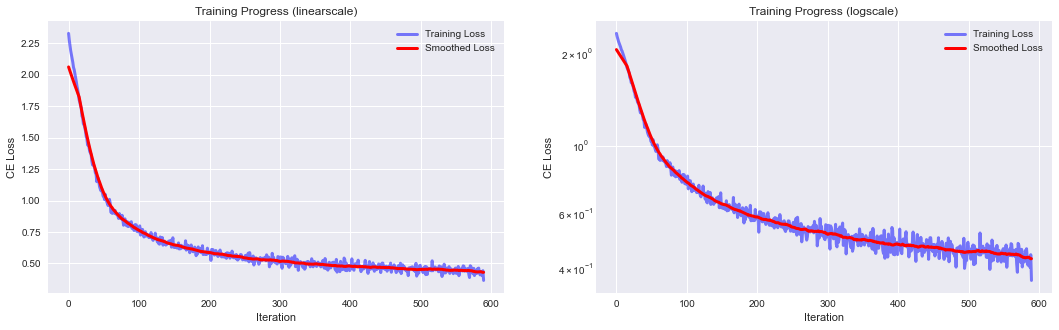

In [23]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_loss = smooth(loss_list, 31)
ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

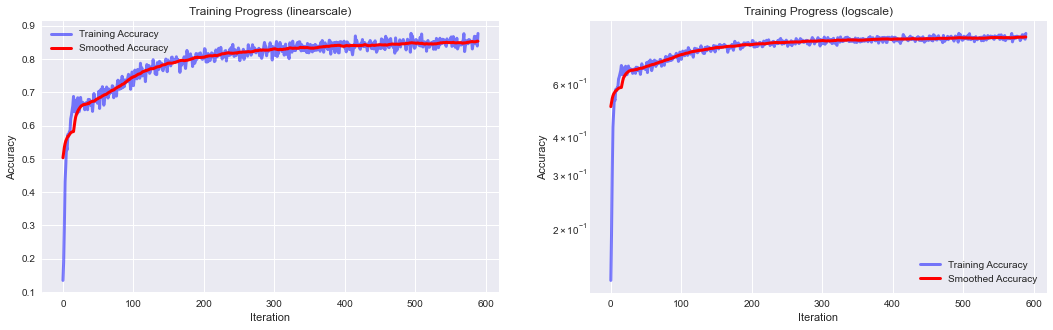

In [24]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_acc = smooth(acc_list, 31)
ax[0].plot(acc_list, c="blue", label="Training Accuracy", linewidth=3, alpha=0.5)
ax[0].plot(smooth_acc, c="red", label="Smoothed Accuracy", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(acc_list, c="blue", label="Training Accuracy", linewidth=3, alpha=0.5)
ax[1].plot(smooth_acc, c="red", label="Smoothed Accuracy", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

## Evaluating Trained Model

In [53]:
n_correct = 0

y_pred = [] # list of predictionsof the model
y_true = [] # list of true labels

eval_loss_list = []

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        y_true.extend(labels.cpu().numpy()) # Save Truth
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)

        
        
        
        pred_labels = torch.argmax(preds, dim=-1)
        loss = criterion(preds, labels)
        eval_loss_list.append(loss.item())

        y_pred.extend(pred_labels.cpu().numpy()) # Save Prediction
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

100%|██████████| 10/10 [00:01<00:00,  7.46it/s]

Test accuracy: 83.64%


In [26]:
eval_loss = np.mean(eval_loss_list)
print(f"Test loss: {round(eval_loss,2)}")

Test loss: 0.47


### Confusion matrix

<AxesSubplot:>

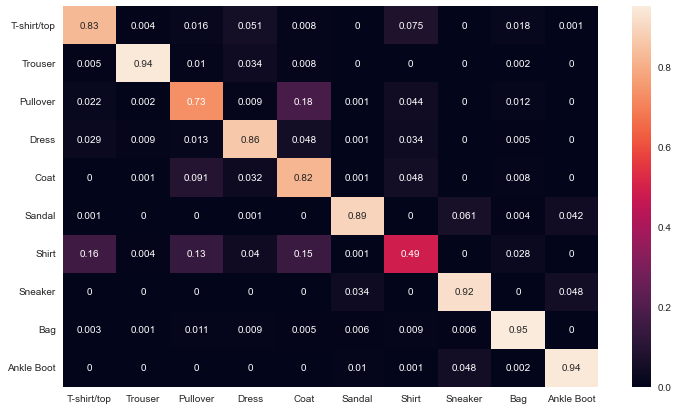

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
# print(y_pred)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

The diagonal of confusion matrix represents the portion of true classified elements. 

The upper rectangle shows the false-negative classificatons, and the lower triangle represents false-positive classifications

We can see that our model has problems with the right classification of "Shirt"-class. The most part of false-positive classified (as "Shirt") elements are from 
"T-shirt/top", "Pullover" and "Coat". Elements of the "Shirt"-class are also false-negative classified as one of these 3 classes (in general about 1.5 times more rear than false-positive results)

The best results our model has in prediction of 'Trouser', 'Bag' and 'Ankle Boot' classes.


## Optimization

In [34]:
CLASSES = 10

def define_model(trial):
    # We optimize the number of layers, hidden units in each layer and activation function.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_layers_dims = []
    for i in range(n_layers):
        max_out_features = 324 // (2 ** i)
        min_out_features = 16 // (2 ** i)
        out_features = trial.suggest_int("n_units_l{}".format(i), min_out_features, max_out_features)
        hidden_layers_dims.append(out_features)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    activation = getattr(nn, activation_name)

    model = Model(hidden_layers_dims=hidden_layers_dims, activation=activation)

    return model


In [35]:
def objective(trial):

    # Generate the model.
    model = define_model(trial).to(device)
    criterion = nn.CrossEntropyLoss() 

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the FashionMNIST dataset.
    train_loader, eval_loader = get_mnist()

    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCH_SIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(eval_loader):
                # Limiting validation data.
                if batch_idx * BATCH_SIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(device), target.to(device)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(eval_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


A single study utilizes only 4-6% of GPU Cuda kernels, and takes a lot of time. We can boost the optimization with Parallelization. <br>
https://hvy-optuna.readthedocs.io/en/latest/tutorial/10_key_features/004_distributed.html

Steps:<br>
(1) start an RDB server (this example uses MySQL) <br>
(2) create a study with –storage argument<br>
(3) share the study among multiple nodes and processes<br>

I have created file optim_parallel.py with the same model and so on, which creates 8 parallel study-processes. 
Only 8 processes, because I don't have enough RAM ;(


In [37]:
try:
    optuna.delete_study(study_name="opt_MLP", storage="mysql://root@localhost/opt_MLP")
except:
    pass

In [38]:
study = optuna.create_study(direction="maximize", study_name="opt_MLP", storage="mysql://root@localhost/opt_MLP", load_if_exists=True)
study.optimize(objective, n_trials=200, timeout=1200)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2022-11-15 22:08:22,602] A new study created in RDB with name: opt_MLP
[I 2022-11-15 22:10:02,264] Trial 0 finished with value: 0.8698 and parameters: {'n_layers': 1, 'n_units_l0': 244, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'lr': 0.002029102197231178}. Best is trial 0 with value: 0.8698.
[I 2022-11-15 22:11:56,340] Trial 18 finished with value: 0.8681 and parameters: {'n_layers': 1, 'n_units_l0': 205, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'lr': 0.02641953490757494}. Best is trial 0 with value: 0.8698.
[I 2022-11-15 22:13:51,353] Trial 29 finished with value: 0.8765 and parameters: {'n_layers': 2, 'n_units_l0': 135, 'n_units_l1': 22, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'lr': 0.005111216837452078}. Best is trial 29 with value: 0.8765.
[I 2022-11-15 22:15:46,078] Trial 40 finished with value: 0.8781 and parameters: {'n_layers': 2, 'n_units_l0': 147, 'n_units_l1': 30, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'lr': 0.008534797952559592}. Best is tri

Study statistics: 
  Number of finished trials:  226
  Number of pruned trials:  164
  Number of complete trials:  53
Best trial:
  Value:  0.8819
  Params: 
    activation: LeakyReLU
    lr: 0.015372986857453516
    n_layers: 1
    n_units_l0: 210
    optimizer: Adam


In [39]:
optuna.visualization.plot_slice(study)

##### Interpretation of slice plot of study:
* Activation function - LeakyReLU gives the best results. All top trials used LeakyReLU
* Learning rate - we can observe a cluster of points close to 0.01 with the best results. 
* Number of Layers -  Models with 1 and 2 hidden layers give the best results. Trials with 2 layers have a bit more dense distribution close to the best result. Trials with 1 hidden layer have a bit wider distribution. The best trial has used 1 hidden layer 
* Number of neurons in the first hidden layer - we can observe a cluster of points with the best results in range 107-236. The winner used 210 points, 2nd and 3d places used 174 and 136 neurons 
* Number of neurons in the second layer - results have wide distribution and don't for clear clusters. 2nd and 3d places used 107 and 35 neurons  
* Number of neurons in the third layer - we can ignore this result as we 1 and 2 hidden layers give the best performance.
* Optimizer - all top 10 results were achieved with Adam optimizer 

In [42]:
optuna.visualization.plot_contour(study, ["n_layers", "n_units_l0", "n_units_l1", "lr", "activation"])

##### Interpretation of contour grid plot of study:
This visualization shows us how the pairs of hyperparameters influent on the results of training.
I do not realy see interesting patterns

In [40]:
optuna.visualization.plot_intermediate_values(study)

#### Intermediate Values Plot 
shows the learning performance of the trials after each of 10 epochs

some of trials were pruned, some models slightly decrease their performance in the middle of the training.
But most of the trials follow the same pattern: they increase their performance after every epoch. This improvements at the beginning are bigger than in the latest epochs. 

### Let's train the model wir the found optimal hyperparameters

In [48]:
model_opt = Model(input_dim=784, hidden_layers_dims=[210], output_dim=10, activation=nn.LeakyReLU).to(device)

optimizer_opt = torch.optim.Adam(model_opt.parameters(), lr=0.01238)
criterion_opt = nn.CrossEntropyLoss()  # already includes a Softmax!

loss_list_opt = []
acc_list_opt = []

norms = [] 

for epoch in range(NUM_EPOCHS):    
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        # using GPU
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model_opt(flattened_imgs)
    
        # computing error
        loss = criterion_opt(preds, labels)
        loss_list_opt.append(loss.item())

        # computing accuracy
        train_acc = (preds.argmax(dim=1) == labels).float().mean()
        acc_list_opt.append(train_acc.item())

        # removing accumulated gradients
        optimizer_opt.zero_grad()
    
        # backprogating error to compute gradients
        loss.backward()

        #  calculating the norm of the gradients for the output layer
        norm_grad = model_opt.layers[-1].weight.grad.norm()
        norms.append(norm_grad.cpu())

        # updating arameters
        optimizer_opt.step()
    
        if(i % 100 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

Epoch 10 Iter 59: loss 0.30027. : 100%|██████████| 59/59 [00:07<00:00,  7.76it/s]


In [49]:
n_correct_opt = 0

y_pred_opt = [] # list of predictionsof the model
y_true_opt = [] # list of true labels

eval_loss_list = []

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        y_true_opt.extend(labels.cpu().numpy()) # Save Truth
        
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model_opt(flattened_imgs)

        
        
        
        pred_labels = torch.argmax(preds, dim=-1)
        loss = criterion(preds, labels)
        eval_loss_list.append(loss.item())

        y_pred_opt.extend(pred_labels.cpu().numpy()) # Save Prediction
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct_opt = n_correct_opt + cur_correct

accuracy_opt = n_correct_opt / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy_opt, 2)}%")

100%|██████████| 10/10 [00:01<00:00,  8.13it/s]

Test accuracy: 87.79%


### Lets compare Confusion matrix of our model with the optimized one

<AxesSubplot:title={'center':'Optimized Model evaluation Confusion matrix'}>

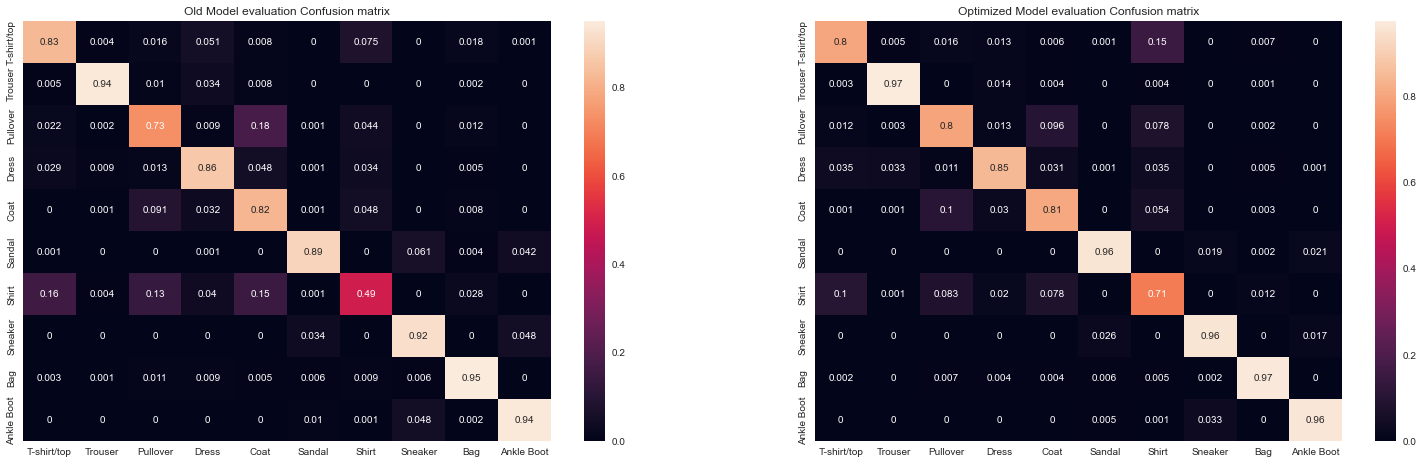

In [51]:
cf_matrix_opt = confusion_matrix(y_true_opt, y_pred_opt)
df_cm_opt = pd.DataFrame(cf_matrix_opt/np.sum(cf_matrix_opt) *10, index = [i for i in classes],
                     columns = [i for i in classes])

# Here we create a figure instance, and two subplots
fig = plt.figure(figsize=(26, 17))

ax1 = fig.add_subplot(221)
ax1.set_title('Old Model evaluation Confusion matrix')
ax2 = fig.add_subplot(222)
ax2.set_title('Optimized Model evaluation Confusion matrix')
# We use ax parameter to tell seaborn which subplot to use for this plot
sn.heatmap(data=df_cm, annot=True, ax=ax1)
sn.heatmap(data=df_cm_opt, annot=True, ax=ax2)



We can see that the results of the optimized model are in general better, but with some exeptions. Classification of "Shirt" is now much better (49%->71). It has less false-positive results in other classes, but more false negetive classifications in "T-shirt/top". Classification of the items from category "Pullover" works less good.

### - Visualize the norm of the gradients for some parameters during training, i.e., how the error decreases for some parameters as the model learns

Lets visualize the norms of gradienst of 10 output-neurons during the training.

The values are collected during the training after every batch

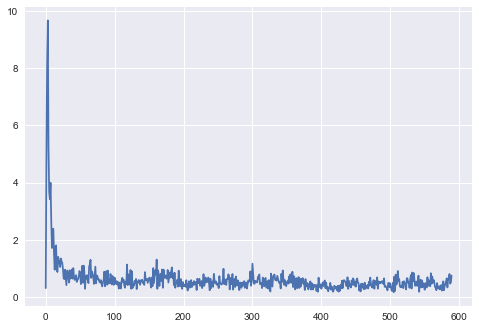

In [52]:

plt.plot(norms)

We can see big pick at the beginnig, then it has small oscelations

